# Timeseries of zonal means from NetCDFs

This notebook uses climate-utils to calculate a timeseries of zonal means of a gridded dataset for example polygon in a coverage

## Requirements

* `climate-utils`:

`$ pip install https://github.com/flowmatters/climate-utils/archive/master.zip`

* A version of `python-rasterstats` with the percent cover option and the ability to return the percent cover masks:

`$ pip install https://github.com/joelrahman/python-rasterstats/archive/percent_cover.zip`

In [1]:
import geopandas as gpd
import pandas as pd
from climate_utils import zonal

%matplotlib inline

## Load the vector coverage

We need it as a Geopandas GeoDataFrame

We also want to know which attribute in the coverage to include in the column name of the resulting time series Data Frame.

In [2]:
coverage = gpd.read_file('LGA11aAust.shp')

# coverage needs to be in same projection as grid. If not, reproject the coverage
# coverage = coverage.to_crs(epsg=4326)

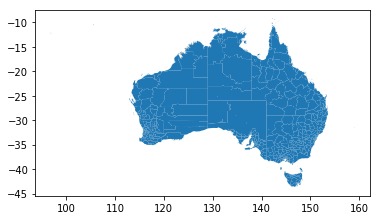

In [3]:
coverage.plot()

In [4]:
coverage.columns

Index(['STATE_CODE', 'LGA_CODE11', 'LGA_NAME11', 'geometry'], dtype='object')

In [5]:
coverage.LGA_CODE11[:10]

0    10050
1    10110
2    10150
3    10200
4    10250
5    10300
6    10350
7    10470
8    10550
9    10600
Name: LGA_CODE11, dtype: object

In [6]:
#coverage.bounds

In [7]:
coverage.total_bounds

array([ 96.81694141, -43.7405096 , 159.10921901,  -9.14217598])

## Need to make sure the coverage fits within the bounds of the grids...

Typically the gridded data sets will exclude a lot of smaller islands and territories that might be included in the polygon coverage.

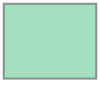

In [8]:
import shapely
box = shapely.geometry.box(112,-44,154,-10) # The bounds of the grid. Could compute from the grids
box

In [9]:
coverage['geometry'] = coverage.geometry.intersection(box)
coverage = coverage[coverage.geometry.notnull()]

In [10]:
coverage.total_bounds

array([112.92111395, -43.7405096 , 153.63872701, -10.01741795])

# Define the storage conventions for the grids

In this example, we have daily time series of gridded rainfall, stored in yearly files

Once we know the pattern, we can define a loader - this will return the data for a given day.

In [11]:
!ls *nc

1970.daily_rain.nc  1982.daily_rain.nc	1994.daily_rain.nc  2006.daily_rain.nc
1971.daily_rain.nc  1983.daily_rain.nc	1995.daily_rain.nc  2007.daily_rain.nc
1972.daily_rain.nc  1984.daily_rain.nc	1996.daily_rain.nc  2008.daily_rain.nc
1973.daily_rain.nc  1985.daily_rain.nc	1997.daily_rain.nc  2009.daily_rain.nc
1974.daily_rain.nc  1986.daily_rain.nc	1998.daily_rain.nc  2010.daily_rain.nc
1975.daily_rain.nc  1987.daily_rain.nc	1999.daily_rain.nc  2011.daily_rain.nc
1976.daily_rain.nc  1988.daily_rain.nc	2000.daily_rain.nc  2012.daily_rain.nc
1977.daily_rain.nc  1989.daily_rain.nc	2001.daily_rain.nc  2013.daily_rain.nc
1978.daily_rain.nc  1990.daily_rain.nc	2002.daily_rain.nc  2014.daily_rain.nc
1979.daily_rain.nc  1991.daily_rain.nc	2003.daily_rain.nc  2015.daily_rain.nc
1980.daily_rain.nc  1992.daily_rain.nc	2004.daily_rain.nc  2016.daily_rain.nc
1981.daily_rain.nc  1993.daily_rain.nc	2005.daily_rain.nc  2017.daily_rain.nc


In [12]:
!ncdump -h 2016.daily_rain.nc

netcdf \2016.daily_rain {
dimensions:
	lat = 681 ;
	lon = 841 ;
	time = UNLIMITED ; // (366 currently)
variables:
	double lat(lat) ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double lon(lon) ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double time(time) ;
		time:units = "days since 2016-01-01" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	short daily_rain(time, lat, lon) ;
		daily_rain:_FillValue = -32768s ;
		daily_rain:scale_factor = 0.1 ;
		daily_rain:add_offset = 0. ;
		daily_rain:units = "mm" ;
		daily_rain:long_name = "Daily rainfall" ;
	char crs ;
		crs:longitude_of_prime_meridian = 0. ;
		crs:semi_major_axis = 6378137. ;
		crs:inverse_flattening = 298.257223563 ;
		crs:grid_mapping_name = "latitude_longitude" ;
		crs:long_name = "Coordinate reference system" ;

// global attributes:
		:institution = "Queensland Governmen

In [13]:
loader = zonal.netcdf_loader('${year}.${variable}.nc',known_bounds=coverage.total_bounds)

# Define the time period of interest

We need a pandas date index or similar

In [19]:
time_period = pd.date_range(pd.datetime(2000,1,1),pd.datetime(2002,12,31))
len(time_period)

1096

In [20]:
time_period

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2002-12-22', '2002-12-23', '2002-12-24', '2002-12-25',
               '2002-12-26', '2002-12-27', '2002-12-28', '2002-12-29',
               '2002-12-30', '2002-12-31'],
              dtype='datetime64[ns]', length=1096, freq='D')

## Run the aggregation

In [21]:
%xmode Verbose
rainfall = zonal.compute_catchment_time_series('daily_rain',
                                               coverage,
                                               time_period,
                                               loader,
                                               name_attribute='LGA_CODE11',
                                               column_naming='${catchment}',
                                               percent_cover_scale=10)

Exception reporting mode: Verbose

2000 1 2 3 4 5 6 7 8 9 10 11 12 
2001 1 2 3 4 5 6 7 8 9 10 11 12 
2002 1 2 3 4 5 6 7 8 9 10 11 12 

In [23]:
rainfall[:20]

,10050,10110,10150,10200,10250,10300,10350,10470,10550,10600,...,72330,72800,73600,74050,74500,74560,74660,79399,89399,99399
2000-01-01,0.000000,1.567289,0.019608,0.000000,14.892379,0.000000,0.176731,0.173355,4.459089,8.527561,...,0.000167,29.150001,0.379694,15.562778,10.692287,34.9000,3.403428,5.843394,0.163978,5.278324
2000-01-02,0.000000,10.850391,0.080392,0.186335,0.829821,0.000000,0.303047,0.000000,0.128905,6.880194,...,0.000000,0.016509,0.714916,0.025581,2.957336,0.0475,0.007733,0.294024,0.000000,7.517052
2000-01-03,0.000000,0.397492,2.250980,2.159006,0.561739,0.014686,5.709418,0.000000,0.082505,1.124737,...,0.063332,3.738679,5.061766,10.384352,8.976212,7.4650,21.310983,16.403166,0.000000,3.658381
2000-01-04,1.415778,0.000000,0.000000,0.000000,0.000000,0.000000,0.006648,0.716194,0.098894,0.007038,...,0.000000,0.095283,1.380715,9.622852,5.317617,0.3650,9.051929,1.822292,0.488177,1.310116
2000-01-05,0.000000,3.864350,0.000000,0.000000,0.000000,0.000000,0.000000,11.396264,0.983365,2.970699,...,0.000000,1.124528,0.745148,0.202400,1.278424,0.0000,1.678809,2.256488,0.110191,0.033237
2000-01-06,0.000000,0.161363,0.000000,0.000000,7.113964,0.000000,0.000000,0.000000,2.460068,0.098037,...,0.012602,8.941038,0.556515,1.961531,4.602430,0.7700,0.017373,1.591610,0.000000,0.000000
2000-01-07,0.000000,1.072584,0.000000,0.000000,11.813402,0.000000,0.000000,0.000000,0.009410,4.427194,...,0.001072,9.880189,19.064884,0.008949,1.891463,0.1950,2.040319,5.740800,0.000000,0.000000
2000-01-08,0.000000,0.193438,3.131373,2.177018,0.167212,0.000000,1.162050,0.000000,0.084712,0.000000,...,0.025683,16.766038,0.563438,0.243776,2.909365,5.4125,1.817756,10.458061,0.000000,2.033237
2000-01-09,0.000000,0.208549,2.047059,0.949068,2.696880,0.000000,0.396676,0.005879,0.151373,1.826763,...,0.810233,2.230189,2.953755,11.970484,1.747991,0.9975,4.825154,6.910079,0.775267,2.717052
2000-01-10,0.000219,1.247440,0.250980,0.332298,12.273453,0.000000,0.440997,0.000000,0.253691,4.527050,...,0.234155,37.015567,3.014838,18.329131,4.036376,24.6375,17.597289,30.334260,3.833887,0.000000
